<a href="https://colab.research.google.com/github/Kulikov17/MLDS_DL/blob/main/HW5/audio_digital_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Скачаем датасет из kaggle

In [1]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory


In [3]:
! kaggle competitions download -c mlds-asr-competition-on-toloka-labelling

 95% 307M/323M [00:05<00:00, 35.1MB/s]
100% 323M/323M [00:05<00:00, 60.9MB/s]


In [ ]:
# !unzip mlds-asr-competition-on-toloka-labelling.zip

In [2]:
import torch
import torch.nn.functional as F
import torchaudio
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pathlib
from tqdm import tqdm
from matplotlib import pyplot as plt
from IPython import display

RANDOM_SEED = 42

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Посмотрим запись из скаченного датасета

In [4]:
wav, sr = torchaudio.load('test/test/file0.mp3', format="mp3")

In [5]:
wav

tensor([[ 0.0001,  0.0002,  0.0002,  ..., -0.0002, -0.0002, -0.0001]])

In [6]:
wav.dtype

torch.float32

In [7]:
wav.shape

torch.Size([1, 34819])

In [8]:
sr

48000

In [9]:
def visualize_audio(wav: torch.Tensor, sr: int = 48000):
    # Average all channels
    if wav.dim() == 2:
        # Any to mono audio convertion
        wav = wav.mean(dim=0)

    plt.figure(figsize=(20, 5))
    plt.plot(wav, alpha=.7, c='green')
    plt.grid()
    plt.xlabel('Time', size=20)
    plt.ylabel('Amplitude', size=20)
    plt.show()

    display.display(display.Audio(wav, rate=sr))

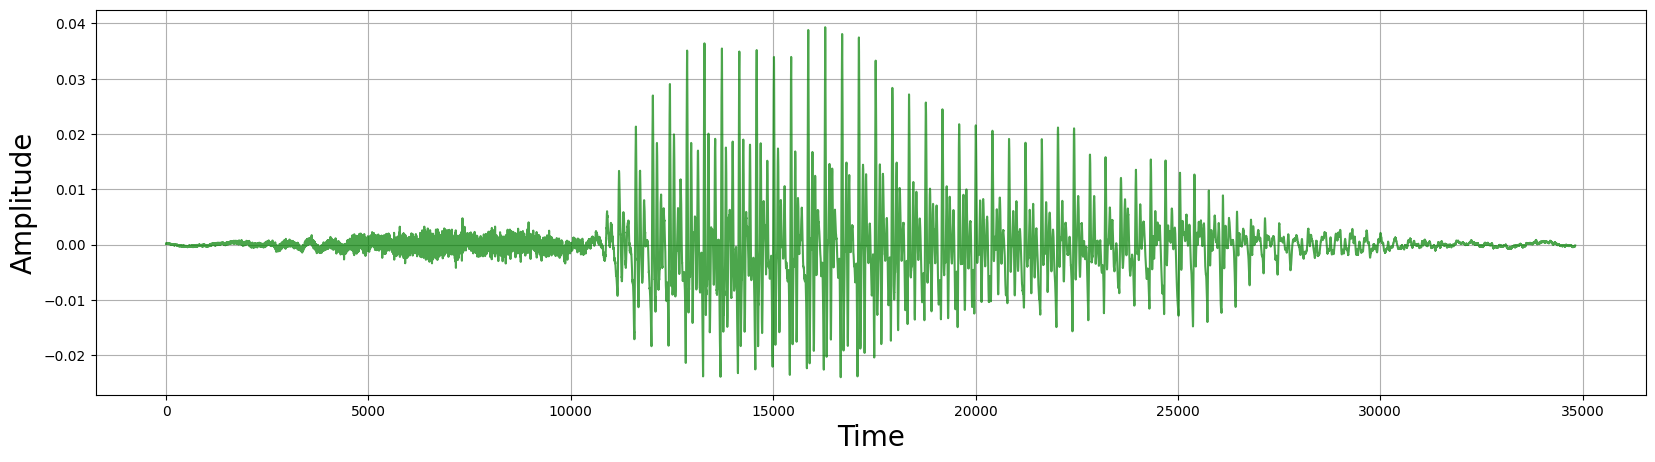

In [10]:
visualize_audio(wav)

In [11]:
class TolokaDataset(Dataset):
    def __init__(self, path_to_data: str):
        self.paths = []

        for i in range(10):
          filenames = pathlib.Path(f'{path_to_data}0{i}')
          files = list(filenames.rglob('*.mp3'))
          self.paths.extend(files)

    def __getitem__(self, index: int):
        path_to_wav = self.paths[index].as_posix()

        # Load mp3
        wav, sr = torchaudio.load(path_to_wav, format="mp3")

        label = int(path_to_wav.split('/')[-2])

        return wav, sr, label

    def __len__(self):
        return len(self.paths)

In [12]:
path_to_dataset = './datasetNumbers/datasetNumbers/'

In [13]:
dataset = TolokaDataset(path_to_dataset)

In [14]:
waveform, sample_rate, label = dataset[0]

Shape of waveform: torch.Size([1, 43248])
Sample rate of waveform: 48000


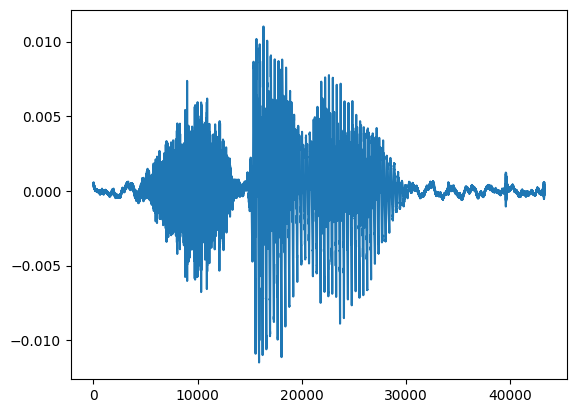

In [15]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [16]:
labels = sorted(list(set(datapoint[2] for datapoint in dataset)))
labels

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

Что касается формы сигнала, мы субдискретизируем звук для более быстрой обработки, не теряя при этом слишком большой мощности классификации.

Нам не нужно применять здесь другие преобразования. Однако для некоторых наборов данных обычно приходится уменьшать количество каналов (скажем, со стерео на моно), либо беря среднее значение по измерению канала, либо просто сохраняя только один из каналов. Поскольку данный датасет использует один канал для звука, здесь это не требуется.

In [17]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

display.Audio(transformed.numpy(), rate=new_sample_rate)

Мы кодируем каждое слово, используя его индекс в списке меток.

In [18]:
def label_to_index(digit):
    # Return the position of the word in labels
    return torch.tensor(labels.index(digit))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


digit_start = 3
index = label_to_index(digit_start)
digit_recovered = index_to_label(index)

print(digit_start, "-->", index, "-->", digit_recovered)

3 --> tensor(3) --> 3


In [19]:
from sklearn.model_selection import train_test_split

train_dataset, validation_dataset = train_test_split(dataset, test_size=0.2, random_state=RANDOM_SEED)

In [20]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [65]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

При выполнении ДЗ, хочу сравнить две модели M5 и M11.

Подробнее см. источники:

1. https://arxiv.org/pdf/1610.00087.pdf
2. https://jovian.com/gtaljaard/assignment-4-speech-command-recognition-with-m3-m5-m11-m18-cnn-networks
3. https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html

In [77]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=4, n_channel=128):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3,stride=1,padding=1)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3,stride=1,padding=1)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 4 * n_channel, kernel_size=3,stride=1,padding=1)
        self.bn4 = nn.BatchNorm1d(4 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(4 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

model_m5 = M5(n_input=transformed.shape[0], n_output=len(labels))
model_m5.to(device)

print(model_m5)
print("Number of parameters: %s" % count_parameters(model_m5))

M5(
  (conv1): Conv1d(1, 128, kernel_size=(80,), stride=(4,))
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear

In [79]:
class M11(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=4, n_channel=64):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)

        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.conv3 = nn.Conv1d(n_channel, n_channel, kernel_size=3,padding=1)
        self.bn3 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)

        self.conv4 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.conv5 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3,padding=1)
        self.bn5 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)

        self.conv6 = nn.Conv1d(2 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn6 = nn.BatchNorm1d(4 * n_channel)
        self.conv7 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn7 = nn.BatchNorm1d(4 * n_channel)
        self.conv8 = nn.Conv1d(4 * n_channel, 4 * n_channel, kernel_size=3,padding=1)
        self.bn8 = nn.BatchNorm1d(4 * n_channel)
        self.pool4 = nn.MaxPool1d(4)

        self.conv9 = nn.Conv1d(4 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn9 = nn.BatchNorm1d(8 * n_channel)
        self.conv10 = nn.Conv1d(8 * n_channel, 8 * n_channel, kernel_size=3,padding=1)
        self.bn10 = nn.BatchNorm1d(8 * n_channel)

        self.fc1 = nn.Linear(8 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool2(x)

        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.conv5(x)
        x = F.relu(self.bn5(x))
        x = self.pool3(x)

        x = self.conv6(x)
        x = F.relu(self.bn6(x))
        x = self.conv7(x)
        x = F.relu(self.bn7(x))
        x = self.conv8(x)
        x = F.relu(self.bn8(x))
        x = self.pool4(x)

        x = self.conv9(x)
        x = F.relu(self.bn9(x))
        x = self.conv10(x)
        x = F.relu(self.bn10(x))

        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model_m11 = M11(n_input=transformed.shape[0], n_output=len(labels))
model_m11.to(device)

print(model_m11)
print("Number of parameters: %s" % count_parameters(model_m11))

M11(
  (conv1): Conv1d(1, 64, kernel_size=(80,), stride=(4,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size

In [70]:
def train(model, optimizer, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [71]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

In [ ]:
log_interval = 20
n_epoch = 30
pbar_update = 1 / (len(train_loader) + len(test_loader))

Обучим M5

In [73]:
optimizer = optim.Adam(model_m5.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

losses = []
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model_m5, optimizer, epoch, log_interval)
        test(model_m5, epoch)
        scheduler.step()


  0%|          | 0.006711409395973154/2 [00:09<47:39, 1434.61s/it]

Train Epoch: 1 [0/30441 (0%)]	Loss: 2.300994


  0%|          | 0.006711409395973154/2 [00:13<1:05:29, 1971.27s/it]


KeyboardInterrupt: ignored

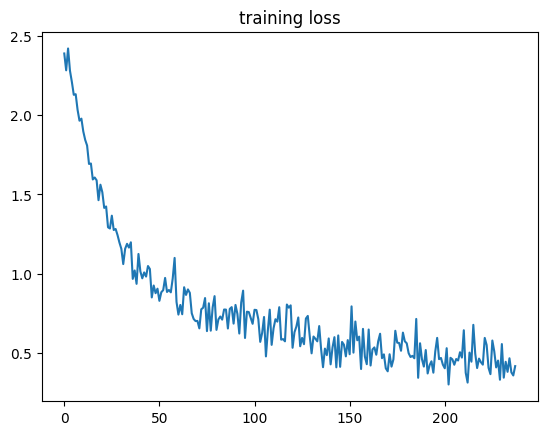

In [45]:
plt.plot(losses);
plt.title("training loss M5");

In [ ]:
torch.save(model_m5.state_dict(), 'm5.model')

Обучим M11

In [ ]:
optimizer = optim.Adam(model_m11.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

losses = []
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model_m11, optimizer, epoch, log_interval)
        test(model_m11, epoch)
        scheduler.step()

In [ ]:
plt.plot(losses);
plt.title("training loss M11");

In [ ]:
torch.save(model_m11.state_dict(), 'm11.model')

In [80]:
def predict(model, tensor):
    model.eval()

    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = torch.unsqueeze(tensor, dim=0)
    tensor = model(tensor)
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())

    return tensor


waveform, sample_rate, label = train_dataset[2]
display.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {label}. Predicted: {predict(model_m11, waveform)}.")

Expected: 8. Predicted: 9.


In [52]:
model.load_state_dict(torch.load('lstm.model', map_location=torch.device(device)))
model.eval()

M11(
  (conv1): Conv1d(1, 64, kernel_size=(80,), stride=(4,))
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size

In [50]:
torch.save(model.state_dict(), 'lstm.model')

Резы для kaggle

In [54]:
class TolokaTestDataset(Dataset):
    def __init__(self, path_to_data: str):
        filenames = pathlib.Path(path_to_data)
        self.paths = list(filenames.rglob('*.mp3'))

    def __getitem__(self, index: int):
        path_to_wav = self.paths[index].as_posix()

        # Load mp3
        wav, sr = torchaudio.load(path_to_wav, format="mp3")

        return wav, sr

    def __len__(self):
        return len(self.paths)

In [55]:
kaggle_test_path = './test/test/'

In [56]:
dataset_kaggle = TolokaTestDataset(kaggle_test_path)

In [58]:
dataset_kaggle[0]

(tensor([[-9.9069e-05, -1.8179e-04, -2.0938e-04,  ..., -6.2837e-05,
          -8.1881e-05, -2.7708e-05]]),
 48000)

In [59]:
row_ids = []
answers = []

for row_id, (waveform, sample_rate) in enumerate(dataset_kaggle):
  row_ids.append(row_id)
  answers.append(predict(waveform))
  break

torch.Size([1, 29904])
torch.Size([1, 4984])


In [63]:
import pandas as pd

df = pd.DataFrame({'row ID': row_ids, 'answer': answers})

In [64]:
with open('csv_data.csv', 'w') as csv_file:
  df.to_csv(path_or_buf=csv_file, index=False, header=['row ID', 'answer'], columns=['row ID', 'answer'])